In [1]:
# Authors: Carolina Fernandez <cxf418@miami.edu>
#          Nick Tolley <nicholas_tolley@brown.edu>
#          Ryan Thorpe <ryan_thorpe@brown.edu>
#          Mainak Jas <mjas@mgh.harvard.edu>

from hnn_core.optimization import Optimizer
from urllib.request import urlretrieve
import os.path as op

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import hnn_core
from hnn_core import (MPIBackend, jones_2009_model, simulate_dipole,
                      read_dipole, JoblibBackend)
from hnn_core.dipole import average_dipoles
from hnn_core.viz import plot_dipole

import pickle
import numpy as np

hnn_core_root = op.join(op.dirname(hnn_core.__file__))

# The number of cores may need modifying depending on your current machine.
n_procs = 1

--No graphics will be displayed.


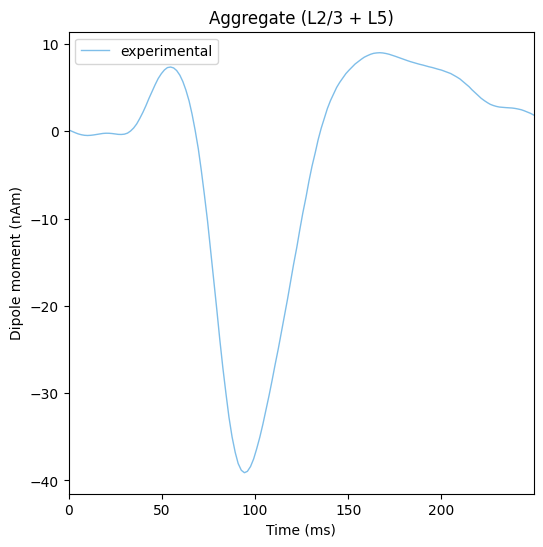

In [3]:
dipole_experimental = read_dipole('../data/L_Contra.txt')

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
dipole_experimental.plot(ax=ax, layer='agg', show=False,
                         color='tab:blue')
ax.legend(['experimental'])

In [4]:
np.corrcoef(dipole_experimental.data['agg'], dipole_experimental.data['agg'])[0, 1]

np.float64(1.0)

In [5]:
def set_params(net, params):

    # Add proximal drives
    weights_ampa_p1 = {"L2_basket": 0.08831 * (10 ** params['evprox1_ampa_L2_basket']),
                       "L2_pyramidal": 0.01525 * (10 ** params['evprox1_ampa_L2_pyramidal']),
                       "L5_basket": 0.19934 * (10 ** params['evprox1_ampa_L5_basket']),
                       "L5_pyramidal": 0.00865 * (10 ** params['evprox1_ampa_L5_pyramidal']),}
    synaptic_delays_p = {"L2_basket": 0.1, "L2_pyramidal": 0.1,
                            "L5_basket": 1.0,"L5_pyramidal": 1.0,}

    # Proximal 1
    net.add_evoked_drive('evprox1',
                         mu=params['evprox1_mu'],
                         sigma=params['evprox1_sigma'],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p1,
                         synaptic_delays=synaptic_delays_p)


    # Add distal drive
    weights_ampa_d1 = {"L2_basket": 0.006562 * (10 ** params['evdist1_ampa_L2_basket']),
                       "L2_pyramidal": 7e-6 * (10 ** params['evdist1_ampa_L2_pyramidal']),
                       "L5_pyramidal": 0.142300 * (10 ** params['evdist1_ampa_L5_pyramidal']),}
    weights_nmda_d1 = {"L2_basket": 0.019482 * (10 ** params['evdist1_nmda_L2_basket']),
                        "L2_pyramidal": 0.004317 * (10 ** params['evdist1_nmda_L2_pyramidal']),
                        "L5_pyramidal": 0.080074 * (10 ** params['evdist1_nmda_L5_pyramidal']),}
    synaptic_delays_d1 = {"L2_basket": 0.1, "L2_pyramidal": 0.1, "L5_pyramidal": 0.1}

    # Distal
    net.add_evoked_drive('evdist1',
                         mu=params['evdist1_mu'],
                         sigma=params['evdist1_sigma'],
                         numspikes=1,
                         location='distal',
                         weights_ampa=weights_ampa_d1,
                         weights_nmda=weights_nmda_d1,
                         synaptic_delays=synaptic_delays_d1)

    # Proximal 2
    weights_ampa_p2 = {'L2_basket': 0.000003 * (10 ** params['evprox2_ampa_L2_basket']),
                       'L2_pyramidal': 1.438840 * (10 ** params['evprox2_ampa_L2_pyramidal']),
                       'L5_basket': 0.008958 * (10 ** params['evprox2_ampa_L5_basket']),
                       'L5_pyramidal': 0.684013 * (10 ** params['evprox2_ampa_L5_pyramidal'])}
    net.add_evoked_drive('evprox2',
                         mu=params['evprox2_mu'],
                         sigma=params['evprox2_sigma'],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p2,
                         synaptic_delays=synaptic_delays_p)


def _rmse(dpl, exp_dpl, tstart=0.0, tstop=0.0, weights=None):
    """Calculates RMSE between data in dpl and exp_dpl
    Parameters
    ----------
    dpl : instance of Dipole
        A dipole object with simulated data
    exp_dpl : instance of Dipole
        A dipole object with experimental data
    tstart : None | float
        Time at beginning of range over which to calculate RMSE
    tstop : None | float
        Time at end of range over which to calculate RMSE
    weights : None | array
        An array of weights to be applied to each point in
        simulated dpl. Must have length >= dpl.data
        If None, weights will be replaced with 1's for typical RMSE
        calculation.

    Returns
    -------
    err : float
        Weighted RMSE between data in dpl and exp_dpl
    """
    from scipy import signal

    exp_times = exp_dpl.times
    sim_times = dpl.times

    # do tstart and tstop fall within both datasets?
    # if not, use the closest data point as the new tstop/tstart
    for tseries in [exp_times, sim_times]:
        if tstart < tseries[0]:
            tstart = tseries[0]
        if tstop > tseries[-1]:
            tstop = tseries[-1]

    # make sure start and end times are valid for both dipoles
    exp_start_index = (np.abs(exp_times - tstart)).argmin()
    exp_end_index = (np.abs(exp_times - tstop)).argmin()
    exp_length = exp_end_index - exp_start_index

    sim_start_index = (np.abs(sim_times - tstart)).argmin()
    sim_end_index = (np.abs(sim_times - tstop)).argmin()
    sim_length = sim_end_index - sim_start_index

    if weights is None:
        # weighted RMSE with weights of all 1's is equivalent to
        # normal RMSE
        weights = np.ones(len(sim_times[0:sim_end_index]))
    weights = weights[sim_start_index:sim_end_index]

    dpl1 = dpl.data["agg"][sim_start_index:sim_end_index]
    dpl2 = exp_dpl.data["agg"][exp_start_index:exp_end_index]

    if sim_length > exp_length:
        # downsample simulation timeseries to match exp data
        dpl1 = signal.resample(dpl1, exp_length)
        weights = signal.resample(weights, exp_length)
        indices = np.where(weights < 1e-4)
        weights[indices] = 0
    elif sim_length < exp_length:
        # downsample exp timeseries to match simulation data
        dpl2 = signal.resample(dpl2, sim_length)

    obj = (-1 * np.corrcoef(dpl1 * weights, dpl2 * weights)[0, 1]) + 1 # transform so that 0 is a perfect fit
    # return np.sqrt((weights * ((dpl1 - dpl2) ** 2)).sum() / weights.sum())

    return obj


def _rmse_evoked(
    initial_net,
    initial_params,
    set_params,
    predicted_params,
    update_params,
    obj_values,
    tstop,
    obj_fun_kwargs,
):
    """The objective function for evoked responses.

    Parameters
    ----------
    initial_net : instance of Network
        The network object.
    initial_params : dict
        Keys are parameter names, values are initial parameters.
    set_params : func
        User-defined function that sets network drives and parameters.
    predicted_params : list
        Parameters selected by the optimizer.
    update_params : func
        Function to update params.
    tstop : float
        The simulated dipole's duration.
    target : instance of Dipole
        A dipole object with experimental data.
    n_trials : int
        Number of trials to simulate and average.

    Returns
    -------
    obj : float
        Normalized RMSE between recorded and simulated dipole.
    """

    params = update_params(initial_params, predicted_params)

    # simulate dpl with predicted params
    new_net = initial_net.copy()
    set_params(new_net, params)

    dpls = simulate_dipole(new_net, tstop=tstop, n_trials=obj_fun_kwargs["n_trials"], dt=obj_fun_kwargs['dt'])

    # smooth & scale
    if "scale_factor" in obj_fun_kwargs:
        [dpl.scale(obj_fun_kwargs["scale_factor"]) for dpl in dpls]
    if "smooth_window_len" in obj_fun_kwargs:
        [dpl.smooth(obj_fun_kwargs["smooth_window_len"]) for dpl in dpls]

    dpl = average_dipoles(dpls)

    obj = _rmse(dpl, obj_fun_kwargs["target"], tstop=tstop)
    obj_values.append(obj)

    print(f'RMSE: {obj:.2f}')

    return obj ** 2

In [6]:
constraints = dict({'evprox1_ampa_L5_pyramidal':(-4, 4),
                    'evprox1_ampa_L2_pyramidal':(-4, 4),
                    'evprox1_ampa_L5_basket':(-4, 4),
                    'evprox1_ampa_L2_basket':(-4, 4),
                    'evprox1_mu': (30., 60.),
                    'evprox1_sigma': (1., 50.),
                    
                    'evdist1_ampa_L5_pyramidal': (-4, 4),
                    'evdist1_nmda_L5_pyramidal': (-4, 4),
                    'evdist1_ampa_L2_pyramidal': (-4, 4),
                    'evdist1_nmda_L2_pyramidal': (-4, 4),
                    'evdist1_ampa_L2_basket': (-4, 4),
                    'evdist1_nmda_L2_basket': (-4, 4),
                    'evdist1_mu': (70., 100.),
                    'evdist1_sigma': (1., 50.),

                    'evprox2_ampa_L5_pyramidal': (-4, 4),
                    'evprox2_ampa_L2_pyramidal': (-4, 4),
                    'evprox2_ampa_L5_basket':(-4, 4),
                    'evprox2_ampa_L2_basket':(-4, 4),
                    'evprox2_mu': (120., 150.),
                    'evprox2_sigma': (1., 50.),
                    })

initial_params = dict({'evprox1_ampa_L5_pyramidal': 0,
                       'evprox1_ampa_L2_pyramidal': 0,
                       'evprox1_ampa_L5_basket': 0,
                       'evprox1_ampa_L2_basket': 0,
                       'evprox1_mu': 60.,
                       'evprox1_sigma': 1.,

                       'evdist1_ampa_L5_pyramidal': 0,
                       'evdist1_nmda_L5_pyramidal': 0,
                       'evdist1_ampa_L2_pyramidal': 0,
                       'evdist1_nmda_L2_pyramidal': 0,
                       'evdist1_ampa_L2_basket': 0,
                       'evdist1_nmda_L2_basket': 0,
                       'evdist1_mu': 100.,
                       'evdist1_sigma': 1.,

                       'evprox2_ampa_L5_pyramidal': 0,
                       'evprox2_ampa_L2_pyramidal': 0,
                       'evprox2_ampa_L5_basket': 0,
                       'evprox2_ampa_L2_basket': 0,
                       'evprox2_mu': 150.,
                       'evprox2_sigma': 1.,
                       
                       })

In [7]:
n_trials = 10
scaling_factor = 1000
# scaling_factor = 2000 # use for dt=0.5
window_length = 40
tstop = 250
dt = 0.025

net = jones_2009_model()
optim = Optimizer(net, tstop=tstop, constraints=constraints, solver='bayesian',
                  set_params=set_params, initial_params=initial_params, max_iter=100, obj_fun=_rmse_evoked)
                

with JoblibBackend(n_jobs=10):
    optim.fit(target=dipole_experimental, n_trials=n_trials, scale_factor=scaling_factor,
            smooth_window_len=window_length, dt=dt)

Joblib will run 10 trial(s) in parallel by distributing trials over 10 jobs.


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /use

In [8]:
with JoblibBackend(n_jobs=10):

        dipoles_optimized = simulate_dipole(
                optim.net_, tstop=tstop, n_trials=n_trials, dt=dt)

# Smooth and scale
for dipole in dipoles_optimized:
    dipole.smooth(window_length).scale(scaling_factor)

Joblib will run 10 trial(s) in parallel by distributing trials over 10 jobs.


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.soLoading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so

Building the NEURON modelBuilding the NEURON model

Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.soLoading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so

Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.soLoading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so

Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Loading cu

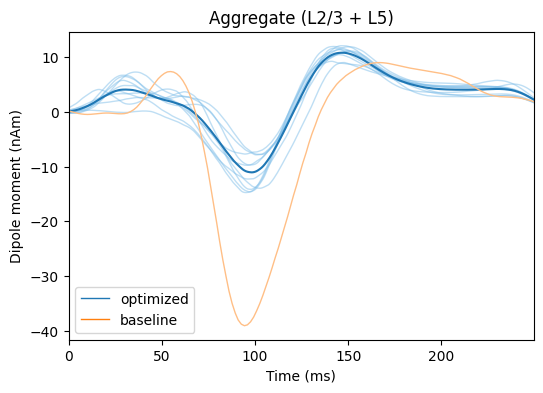

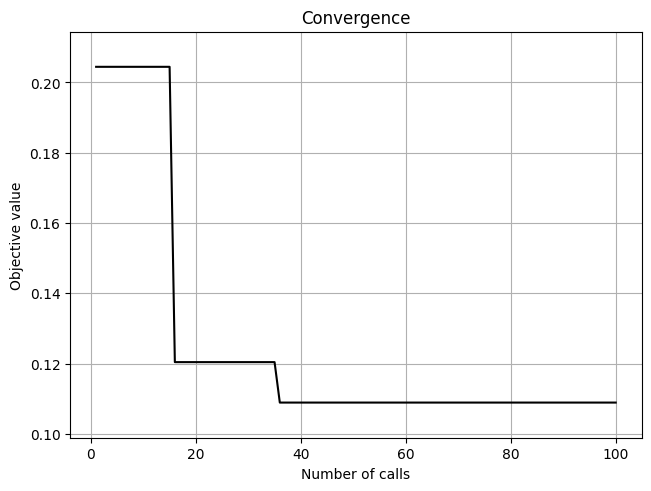

In [11]:
fig, ax = plt.subplots(sharex=True, figsize=(6,4))

plot_dipole(dipoles_optimized.copy(), ax=ax, layer='agg',
            show=False, color='tab:blue', average=True)
dipole_experimental.plot(ax=ax, layer='agg', show=False,
                         color='tab:orange')

# Legend
legend_handles = [Line2D([0], [0], color='tab:blue', lw=1.0),
                  Line2D([0], [0], color='tab:orange', lw=1.0),
                  Line2D([0], [0], color='tab:green', lw=1.0)]
ax.legend(legend_handles, ['optimized', 'baseline'])

# Convergence plot
optim.plot_convergence()
# plt.ylim(3, 11)
plt.show()

In [ ]:
# optim.net_.write_configuration('../data/opt_baseline_config_correlation.json')

# with open('../data/opt_baseline_object_correlation.pkl', 'wb') as file:
#     pickle.dump(optim, file)